<h1>Backtest common trading strategies</h1>

In [55]:
%pip install backtrader
%pip install matplotlib
%pip install pandas
%matplotlib inline

from consts import *
import backtrader as bt
import uts
import pandas as pd
import random
from IPython.display import display

utils = uts.Utilities(is_test=IS_TEST, test_num=TEST_NUM)
etf_dfs = utils.get_dataframes('data/ETFs')
stock_dfs = utils.get_dataframes('data/Stocks')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [56]:
class PandasDataWithDate(bt.feeds.PandasData):
    params = (
        ('datetime', None),
    )

class AllInSizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            size = int(cash / data.close[0])
        else:
            size = self.broker.getposition(data).size
        return size

class ResetMixin():
    def _reset_trade_vars(self):
        self.buy_price = None
        self.take_profit_price = None
        self.stop_loss_price = None

class CrossoverMixin():
    def crossover_next(self):
        price = self.data.close[0]

        if not self.position:
            if self.crossover > 0:
                self.buy()
                self.buy_price = price
                self.take_profit_price = price * (1 + TAKE_PROFIT_PCT)
                self.stop_loss_price = price * (1 - STOP_LOSS_PCT)
        else:
            if price >= self.take_profit_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price <= self.stop_loss_price:
                self.sell()
                self._reset_trade_vars()
                return

            if self.crossover < 0:
                self.sell()
                self._reset_trade_vars()

class MACDStrategy(bt.Strategy, CrossoverMixin, ResetMixin):
    def __init__(self, param):
        macd = bt.ind.MACD(
            self.data.close,
            period_me1=param[0],
            period_me2=param[1],
            period_signal=param[2]
        )
        self.macd = macd.macd
        self.signal = macd.signal
        self.crossover = bt.ind.CrossOver(self.macd, self.signal)
        self._reset_trade_vars()
    
    def next(self):
        super().crossover_next()

class SmaCrossStrategy(bt.Strategy, CrossoverMixin, ResetMixin):
    def __init__(self, param):
        sma1 = bt.ind.SMA(period=param[0])
        sma2 = bt.ind.SMA(period=param[1])
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        self._reset_trade_vars()

    def next(self):
        super().crossover_next()

class RSIStrategy(bt.Strategy, ResetMixin):
    def __init__(self, param):
        self.rsi = bt.ind.RSI(period=param[0])
        self.param = param
        self._reset_trade_vars()
    
    def next(self):
        price = self.data.close[0]

        if not self.position:
            if self.rsi < self.param[1]:
                self.buy()
                self.buy_price = price
                self.take_profit_price = price * (1 + TAKE_PROFIT_PCT)
                self.stop_loss_price = price * (1 - STOP_LOSS_PCT)
        else:
            if price >= self.take_profit_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price <= self.stop_loss_price:
                self.sell()
                self._reset_trade_vars()
                return

            if self.rsi > self.param[2]:
                self.sell()
                self._reset_trade_vars()

class BBStrategy(bt.Strategy, ResetMixin):
    def __init__(self, param):
        self.bb = bt.ind.BollingerBands(
            period=param[0],
            devfactor=param[1]
        )
        self._reset_trade_vars()

    def next(self):
        price = self.data.close[0]

        if not self.position:
            if price < self.bb.lines.bot[0]:
                self.buy()
                self.buy_price = price
                self.take_profit_price = self.buy_price * (1 + TAKE_PROFIT_PCT)
                self.stop_loss_price = self.buy_price * (1 - STOP_LOSS_PCT)
        else:
            if price >= self.take_profit_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price <= self.stop_loss_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price > self.bb.lines.mid[0]:
                self.sell()
                self._reset_trade_vars()

class MACD_RSI_Strategy(bt.Strategy, ResetMixin):
    def __init__(self, param):
        macd = bt.ind.MACD(
            self.data.close,
            period_me1=param[0],
            period_me2=param[1],
            period_signal=param[2]
        )
        self.macd = macd.macd
        self.macd_signal = macd.signal
        self.crossover = bt.ind.CrossOver(self.macd, self.macd_signal)
        self.rsi = bt.ind.RSI(self.data.close, period=param[3])
        self.param = param
        self._reset_trade_vars()

    def next(self):
        if not self.position:
            if self.crossover > 0 and self.rsi < self.param[4]:
                self.buy_price = self.data.close[0]
                self.take_profit_price = self.buy_price * (1 + TAKE_PROFIT_PCT)
                self.buy()
        else:
            if self.data.close[0] < self.buy_price * (1 - STOP_LOSS_PCT):
                self.close()
                self._reset_trade_vars()
                return

            if self.data.close[0] >= self.take_profit_price:
                self.close()
                self._reset_trade_vars()
                return

            if self.crossover < 0 or self.rsi > self.param[5]:
                self.close()
                self._reset_trade_vars()

class BuyAndHoldStrategy(bt.Strategy):
    def __init__(self):
        self.bought = False 

    def next(self):
        if not self.bought:
            cash = self.broker.get_cash()
            price = self.data.close[0]
            size = int(cash / price)
            if size > 0:
                self.buy(size=size)
                self.bought = True

def run_backtest(dfs, num_of_plots):
    def add_asset_perf(vals, table):
        table['Name'].append(vals['name'])
        table['Strategy'].append(vals['strat'])
        table['Parameters'].append(vals['param'])
        table['Value'].append(vals['value'])
        table['Diff'].append(vals['diff'])
        table['Interval'].append(vals['interval'])

    perf_table = {
        'Name': [],
        'Strategy': [],
        'Parameters': [],
        'Value': [],
        'Diff': [],
        'Interval': []
    }
    backtest_options = {
        'macd': {
            'params': [
                (5, 35, 5),
                (8, 17, 9),
                (3, 10, 16),
                (19, 39, 9),
                (12, 26, 5)
            ],
            'class': MACDStrategy
        },
        'sma_cross': {
            'params': [
                (10, 30),
                (15, 50),
                (20, 50),
                (50, 100),
                (50, 200)
            ],
            'class': SmaCrossStrategy
        },
        'rsi': {
            'params': [
                (14, 30, 70),
                (9, 25, 75),
                (5, 20, 80),
                (21, 35, 65),
                (28, 40, 60)
            ],
            'class': RSIStrategy
        },
        'bollinger_bands': {
            'params': {
                (20, 2.0),
                (10, 1.5),
                (14, 1.5),
                (50, 2.0),
                (100, 2.0)
            },
            'class': BBStrategy
        },
        'macd_rsi': {
            'params': {
                (12, 26, 9, 14, 30, 70),
                (5, 35, 5, 10, 25, 75),
                (8, 17, 9, 7, 20, 80),
                (10, 30, 10, 20, 40, 60),
                (6, 19, 3, 5, 28, 72)
            },
            'class': MACD_RSI_Strategy
        }
    }

    num_of_params = 0
    for strat, v in backtest_options.items():
        for param in v['params']:
            num_of_params += 1
    nop = len(dfs[:3]) * num_of_params
    plot_inds = [random.randint(0, nop - 1) for _ in range(num_of_plots)]
    k = 0

    for df in dfs[:3]:
        try:
            for strat, v in backtest_options.items():
                for param in v['params']:
                    cerebro = bt.Cerebro()
                    data = PandasDataWithDate(dataname=df)

                    cerebro.adddata(data)
                    cerebro.addstrategy(v['class'], param)
                    cerebro.broker.set_cash(INIT_CASH) 
                    cerebro.broker.setcommission(commission=0.001, margin=1.0, mult=1.0)  
                    cerebro.addsizer(AllInSizer)
                    cerebro.run()
                    if k in plot_inds:
                        figs = cerebro.plot(figsize=(12, 10))
                        fig = figs[0][0]  
                        display(fig)
                    add_asset_perf({
                        'name': df.name,
                        'strat': strat,
                        'param': param,
                        'value': cerebro.broker.get_value(),
                        'diff': str(round(cerebro.broker.get_value() / INIT_CASH * 100 - 100, 2)) + "%",
                        'interval': df.index.max() - df.index.min()
                    }, perf_table)
                    k += 1
            cerebro = bt.Cerebro()
            data = bt.feeds.PandasData(dataname=df)
            cerebro.adddata(data)
            cerebro.addstrategy(BuyAndHoldStrategy)
            cerebro.broker.set_cash(INIT_CASH) 
            cerebro.addsizer(AllInSizer)
            cerebro.run()
            add_asset_perf({
                'name': df.name,
                'strat': 'buy_and_hold',
                'param': '-',
                'value': round(cerebro.broker.get_value()),
                'diff': str(round(cerebro.broker.get_value() / INIT_CASH * 100 - 100, 2)) + "%",
                'interval': df.index.max() - df.index.min()
            }, perf_table)
        except Exception as e:
            print(e)
            pass
    pdv = pd.DataFrame(perf_table)
    pdv = pdv.sort_values(by='Value', ascending=False)
    return pdv

<IPython.core.display.Javascript object>

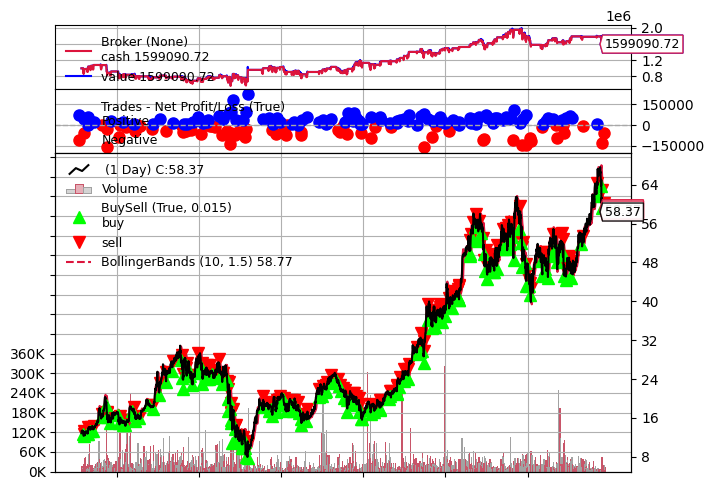

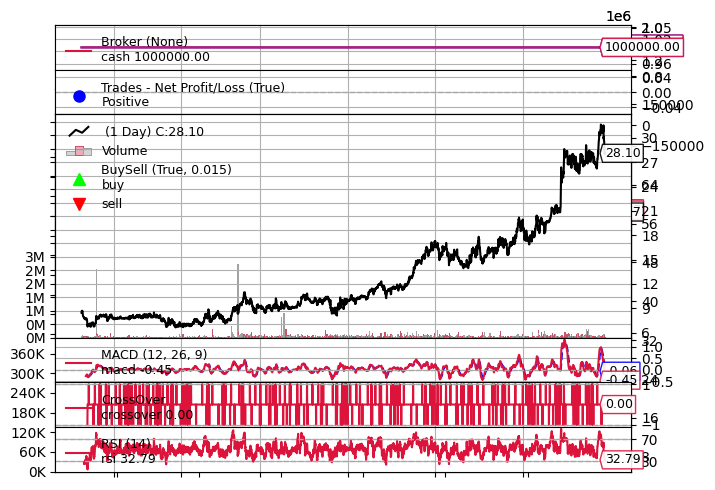

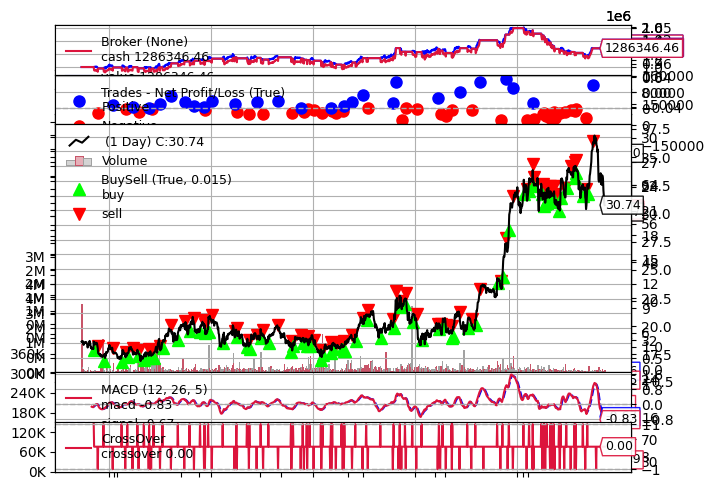

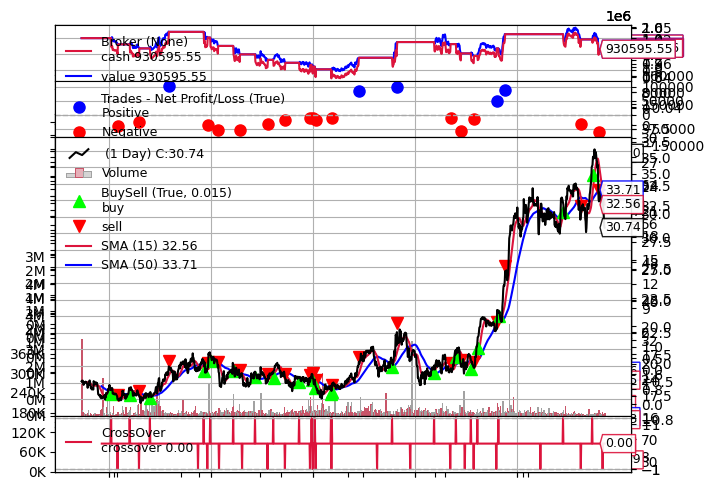

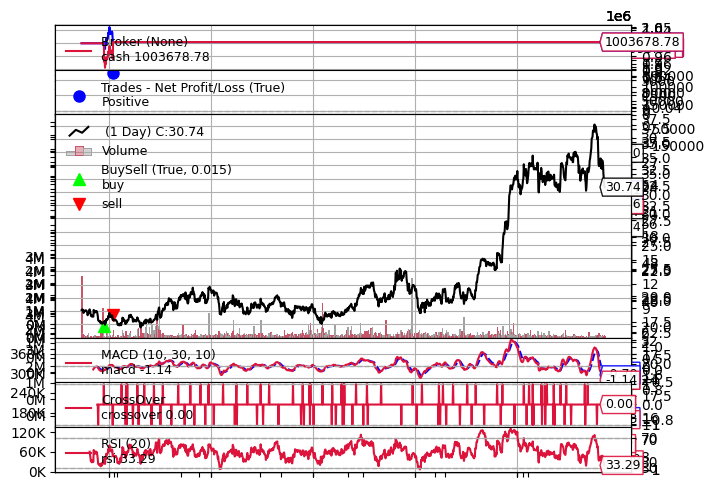

,Name,Strategy,Parameters,Value,Diff,Interval
2,IBA,macd,"(3, 10, 16)",7.133005e+06,613.3%,4641 days
5,IBA,sma_cross,"(10, 30)",3.372536e+06,237.25%,4641 days
51,FLIC,buy_and_hold,-,3.323929e+06,232.39%,4641 days
0,IBA,macd,"(5, 35, 5)",3.284959e+06,228.5%,4641 days
12,IBA,rsi,"(5, 20, 80)",3.212111e+06,221.21%,4641 days
...,...,...,...,...,...,...
34,FLIC,sma_cross,"(50, 100)",9.337238e+05,-6.63%,4641 days
58,NBHC,sma_cross,"(15, 50)",9.305956e+05,-6.94%,1877 days
26,FLIC,macd,"(5, 35, 5)",7.597301e+05,-24.03%,4641 days
6,IBA,sma_cross,"(15, 50)",7.302027e+05,-26.98%,4641 days


In [57]:
res = run_backtest(stock_dfs, NUM_OF_PLOTS)
res

<IPython.core.display.Javascript object>

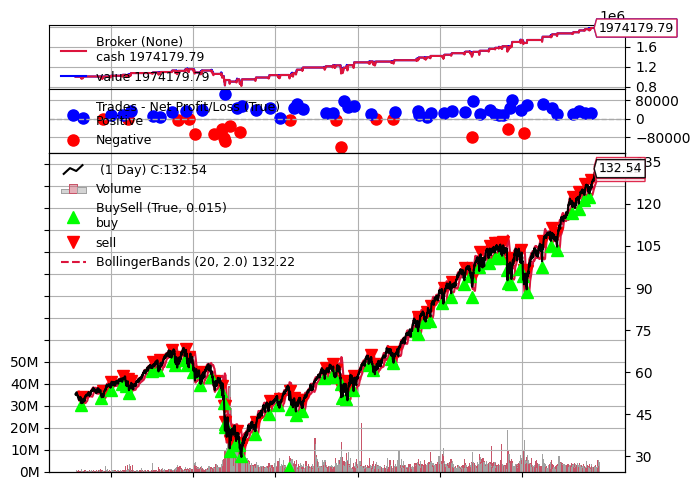

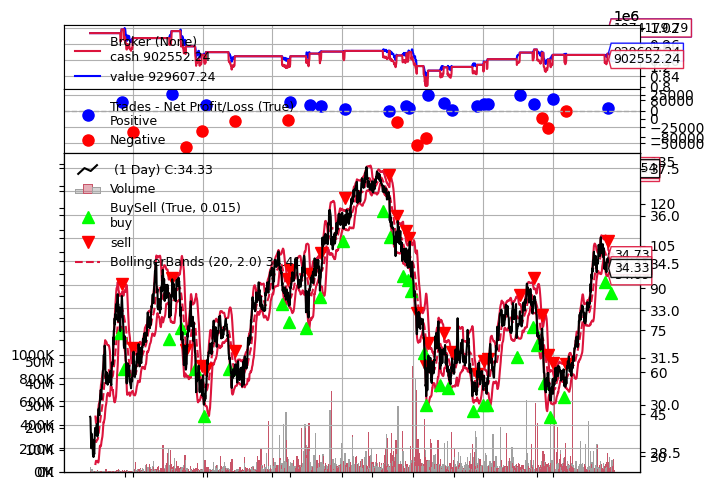

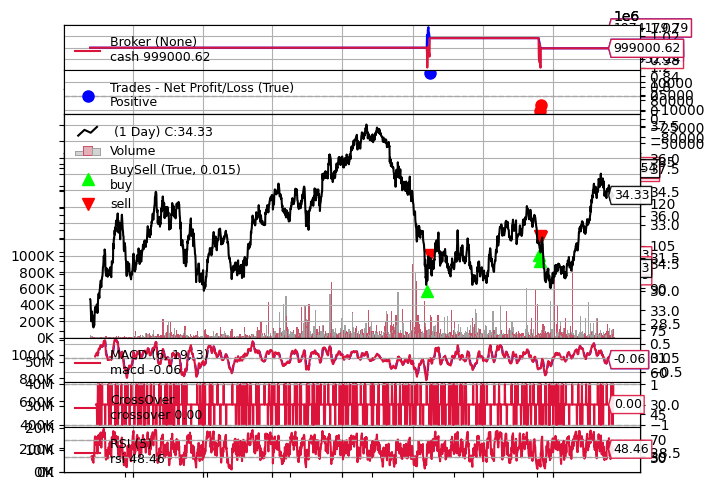

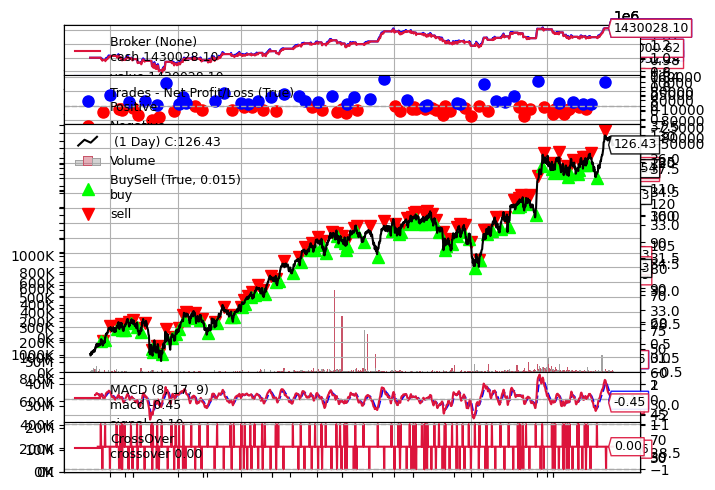

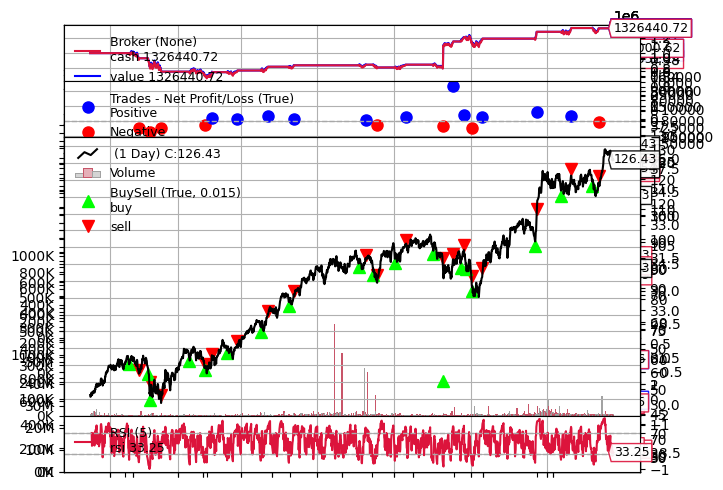

,Name,Strategy,Parameters,Value,Diff,Interval
17,VTI,bollinger_bands,"(10, 1.5)",3077872.043,207.79%,4641 days
16,VTI,bollinger_bands,"(14, 1.5)",2906157.168,190.62%,4641 days
77,VIOV,buy_and_hold,-,2645342.000,164.53%,2614 days
25,VTI,buy_and_hold,-,2541854.000,154.19%,4641 days
5,VTI,sma_cross,"(10, 30)",2169904.498,116.99%,4641 days
...,...,...,...,...,...,...
15,VTI,bollinger_bands,"(50, 2.0)",938286.836,-6.17%,4641 days
44,IBND,bollinger_bands,"(20, 2.0)",929607.239,-7.04%,2731 days
41,IBND,bollinger_bands,"(50, 2.0)",909158.447,-9.08%,2731 days
61,VIOV,sma_cross,"(50, 200)",581290.404,-41.87%,2614 days


In [58]:
res = run_backtest(etf_dfs, NUM_OF_PLOTS)
res